In [100]:
pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [101]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [102]:
train_path = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/train.csv"
test_path  = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/test.csv"
store_path = "/Users/pranjalsharma/Downloads/sales-forecasting/archive/store.csv"


In [103]:
train = pd.read_csv(train_path)


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/3098077256.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(train_path)


In [104]:
test  = pd.read_csv(test_path)


In [105]:
store = pd.read_csv(store_path)

In [106]:
print(train.shape, test.shape, store.shape)
train.head()

(1017209, 9) (41088, 8) (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Extracting Time Features

In [107]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date']  = pd.to_datetime(test['Date'])


In [108]:
for df in [train, test]:
    df['Year']  = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day']   = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

In [109]:
df = train.merge(store, on='Store', how='left')
print(df.shape)
df.head()

(1017209, 21)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,4,2015-07-31,5263,555,1,1,0,1,2015,...,31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4,2015-07-31,6064,625,1,1,0,1,2015,...,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,4,2015-07-31,8314,821,1,1,0,1,2015,...,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,2015-07-31,13995,1498,1,1,0,1,2015,...,31,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,2015-07-31,4822,559,1,1,0,1,2015,...,31,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [110]:
df.isnull().sum().sort_values(ascending=False)


PromoInterval                508031
Promo2SinceYear              508031
Promo2SinceWeek              508031
CompetitionOpenSinceYear     323348
CompetitionOpenSinceMonth    323348
CompetitionDistance            2642
Day                               0
Promo2                            0
Assortment                        0
StoreType                         0
Store                             0
DayOfWeek                         0
Year                              0
SchoolHoliday                     0
StateHoliday                      0
Promo                             0
Open                              0
Customers                         0
Sales                             0
Date                              0
Month                             0
dtype: int64

In [111]:
# CompetitionDistance: replace NaN with median
df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)

# CompetitionOpenSince* → fill with mode or backfill
df['CompetitionOpenSinceYear'].fillna(df['Year'], inplace=True)
df['CompetitionOpenSinceMonth'].fillna(df['Month'], inplace=True)

# Promo2-related
df['Promo2SinceYear'].fillna(0, inplace=True)
df['Promo2SinceWeek'].fillna(0, inplace=True)
df['PromoInterval'].fillna('None', inplace=True)


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/4209162034.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(df['CompetitionDistance'].median(), inplace=True)
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/4209162034.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

In [112]:
# Convert to category dtype
cat_cols = ['StoreType', 'Assortment', 'PromoInterval']
for col in cat_cols:
    df[col] = df[col].astype('category')

# One-hot encode
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [113]:
# Weekend / weekday flag
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Competition active flag
df['CompetitionOpen'] = (
    12 * (df['Year'] - df['CompetitionOpenSinceYear']) +
    (df['Month'] - df['CompetitionOpenSinceMonth'])
)
df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: 1 if x > 0 else 0)

# Promo ongoing flag
df['IsPromo'] = df['Promo'].astype(int)


In [114]:
print(df.describe())
print(df.info())

# Total unique stores
print("Number of stores:", df['Store'].nunique())


              Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06                        1017209   
mean   5.584297e+02  2.998341e+00  2014-04-11 01:30:42.846061824   
min    1.000000e+00  0.000000e+00            2013-01-01 00:00:00   
25%    2.800000e+02  1.000000e+00            2013-08-17 00:00:00   
50%    5.580000e+02  3.000000e+00            2014-04-02 00:00:00   
75%    8.380000e+02  5.000000e+00            2014-12-12 00:00:00   
max    1.115000e+03  6.000000e+00            2015-07-31 00:00:00   
std    3.219087e+02  1.997391e+00                            NaN   

              Sales     Customers          Open         Promo  SchoolHoliday  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06   
mean   5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.0

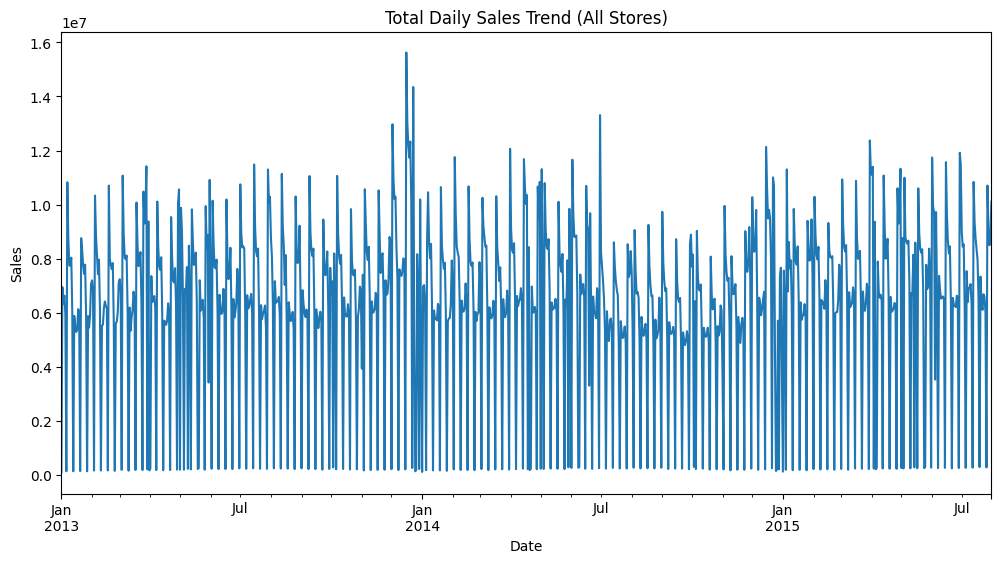

In [115]:
daily_sales = df.groupby('Date')['Sales'].sum()

plt.figure(figsize=(12,6))
daily_sales.plot()
plt.title('Total Daily Sales Trend (All Stores)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


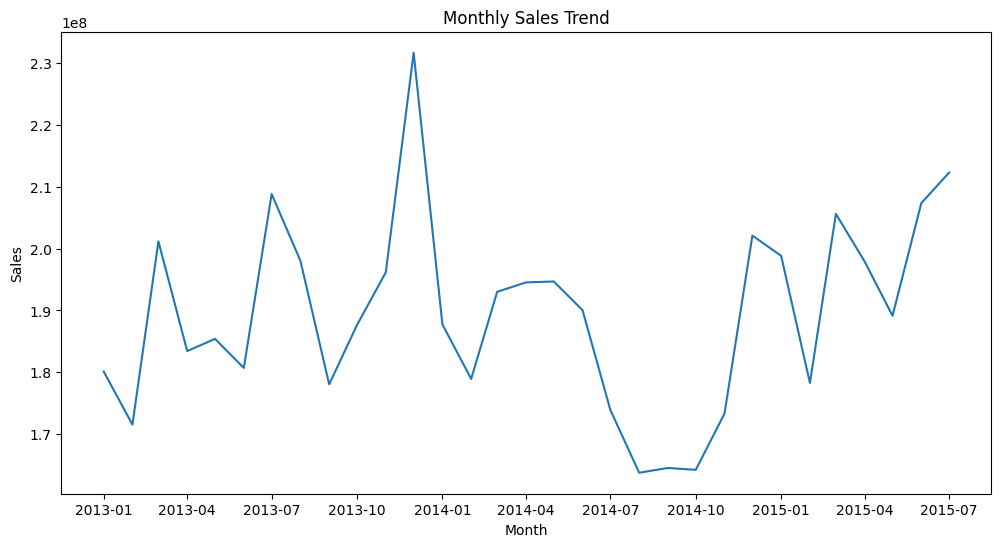

In [116]:
monthly_sales = df.groupby(['Year','Month'])['Sales'].sum().reset_index()
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales[['Year','Month']].assign(DAY=1))

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Sales'])
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()


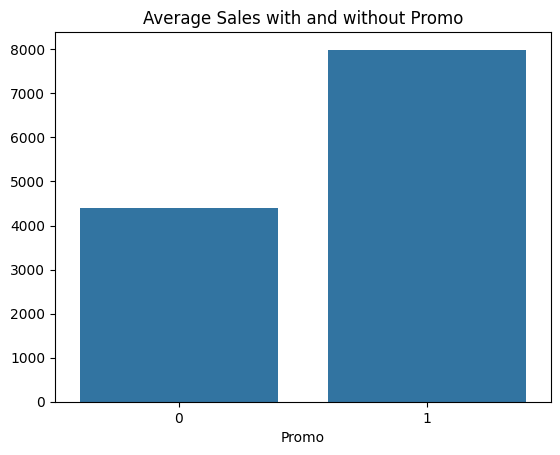

In [117]:
promo_effect = df.groupby('Promo')['Sales'].mean()
sns.barplot(x=promo_effect.index, y=promo_effect.values)
plt.title('Average Sales with and without Promo')
plt.show()


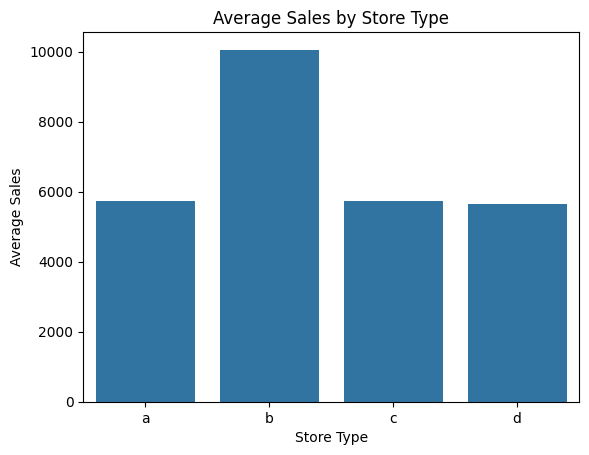

In [118]:
avg_sales_type = train.merge(store, on='Store', how='left').groupby('StoreType')['Sales'].mean()
sns.barplot(x=avg_sales_type.index, y=avg_sales_type.values)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()


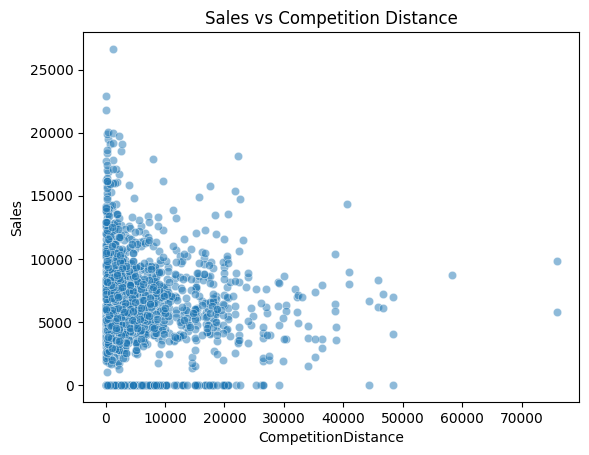

In [119]:
sns.scatterplot(data=df.sample(2000), x='CompetitionDistance', y='Sales', alpha=0.5)
plt.title('Sales vs Competition Distance')
plt.show()


In [120]:
# Filter one store (you can loop later)
store_id = 1
store_df = df[df['Store'] == store_id].sort_values('Date')
store_df = store_df[store_df['Open'] == 1][['Date', 'Sales', 'Promo']]
store_df.set_index('Date', inplace=True)


In [121]:
store_df.index = pd.to_datetime(store_df.index)


In [122]:
# Train-test split
train_data = store_df.iloc[:-60]   # all but last 60 days
test_data  = store_df.iloc[-60:]   # last 60 days for evaluation


In [123]:
model = SARIMAX(
    train_data['Sales'],
    exog=train_data[['Promo']],            # exogenous variable
    order=(1,1,1),
    seasonal_order=(1,1,1,7),              # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
train_pred = results.fittedvalues
test_forecast = results.get_forecast(steps=len(test_data),
                                     exog=test_data[['Promo']]).predicted_mean

/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this metho

In [124]:
train_data['Residuals'] = train_data['Sales'] - train_pred


/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/949765598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Residuals'] = train_data['Sales'] - train_pred


In [129]:
# 1. Uninstall the existing package
!pip uninstall lightgbm -y

Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0


In [131]:
print("Attempting to install libomp (required dependency)...")
!brew install libomp
print("If the above showed 'Already installed' or 'Installed', proceed. If it failed, use your external terminal.")

Attempting to install libomp (required dependency)...
To reinstall 21.1.4, run:
  brew reinstall libomp
If the above showed 'Already installed' or 'Installed', proceed. If it failed, use your external terminal.


In [132]:
# 3. Reinstall LightGBM, forcing a source build with the Homebrew linking flags.
# This entire command must run in one go.
print("Starting forced reinstallation with linking flags...")
!LDFLAGS="-L/opt/homebrew/opt/libomp/lib" CPPFLAGS="-I/opt/homebrew/opt/libomp/include" pip install lightgbm --no-binary lightgbm
print("Installation attempt complete. Check the output for 'Successfully installed'.")

Starting forced reinstallation with linking flags...
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.4 MB/s  0:00:01 eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.6.0-py3-none-macosx_15_0_arm64.whl size=1514457 sha256=38a37021b16b43b6ed136456a2f5f442a67b6585091c6c1651f1ed9126e6cbaf
  Stored in directory: /Users/pranjalsharma/Library/Caches/pip/wheels/25/7d/17/7b86ac11153bfe8f4ec30f8439283b0e76428a6be5d9cb0d4a
Successfully built lightgbm
Installation attempt complete. Check the output for 'Successfully installed'.


In [133]:
# 4. Restart the kernel, then run this cell to verify
import lightgbm as lgb
print(f"LightGBM imported successfully! Version: {lgb.__version__}")

LightGBM imported successfully! Version: 4.6.0


In [134]:
train_data['Lag_1'] = train_data['Sales'].shift(1)
train_data['Lag_7'] = train_data['Sales'].shift(7)
train_data['RollingMean_7'] = train_data['Sales'].shift(1).rolling(window=7).mean()
train_data['DayOfWeek'] = train_data.index.dayofweek
train_data = train_data.dropna()

/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/1621782072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Lag_1'] = train_data['Sales'].shift(1)
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/1621782072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Lag_7'] = train_data['Sales'].shift(7)
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/1621782072.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [135]:
X_train = train_data[['Promo', 'Lag_1', 'Lag_7', 'RollingMean_7', 'DayOfWeek']]
y_train = train_data['Residuals']

In [136]:
lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 714, number of used features: 5
[LightGBM] [Info] Start training from score -13.612425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              n_estimators=500, random_state=42, subsample=0.8)

In [138]:

# 1. SARIMAX base forecast
sarimax_forecast = results.get_forecast(
    steps=len(test_data),
    exog=test_data[['Promo']]
).predicted_mean

/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pranjalsharma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [140]:
# 2. ML correction forecast
test_data['Lag_1'] = train_data['Sales'].iloc[-1]  # last known value
test_data['Lag_7'] = train_data['Sales'].iloc[-7] if len(train_data) > 7 else train_data['Sales'].iloc[-1]
test_data['RollingMean_7'] = train_data['Sales'].iloc[-7:].mean()
test_data['DayOfWeek'] = test_data.index.dayofweek

X_test = test_data[['Promo', 'Lag_1', 'Lag_7', 'RollingMean_7', 'DayOfWeek']]
ml_correction = lgbm.predict(X_test)

/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/2678451240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Lag_1'] = train_data['Sales'].iloc[-1]  # last known value
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/2678451240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Lag_7'] = train_data['Sales'].iloc[-7] if len(train_data) > 7 else train_data['Sales'].iloc[-1]
/var/folders/lh/7d8p88ps5rx0l3scbz88rbph0000gn/T/ipykernel_28897/2678451240.py:

In [141]:
# 3. Final hybrid forecast
hybrid_forecast = sarimax_forecast + ml_correction



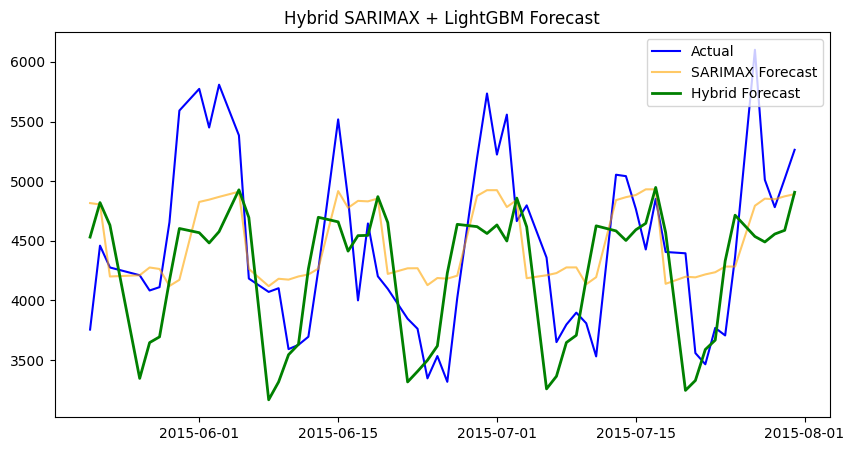

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test_data.index, test_data['Sales'], label='Actual', color='blue')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', color='orange', alpha=0.6)
plt.plot(test_data.index, hybrid_forecast, label='Hybrid Forecast', color='green', linewidth=2)
plt.legend(); plt.title("Hybrid SARIMAX + LightGBM Forecast"); plt.show()

In [143]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # avoid divide-by-zero
    return np.mean(diff) * 100

In [144]:
y_true = test_data['Sales']
y_pred_sarimax = sarimax_forecast
y_pred_hybrid = hybrid_forecast

smape_hybrid = smape(y_true, y_pred_hybrid)

print(f"Hybrid SMAPE : {smape_hybrid:.2f}%")


Hybrid SMAPE : 12.13%


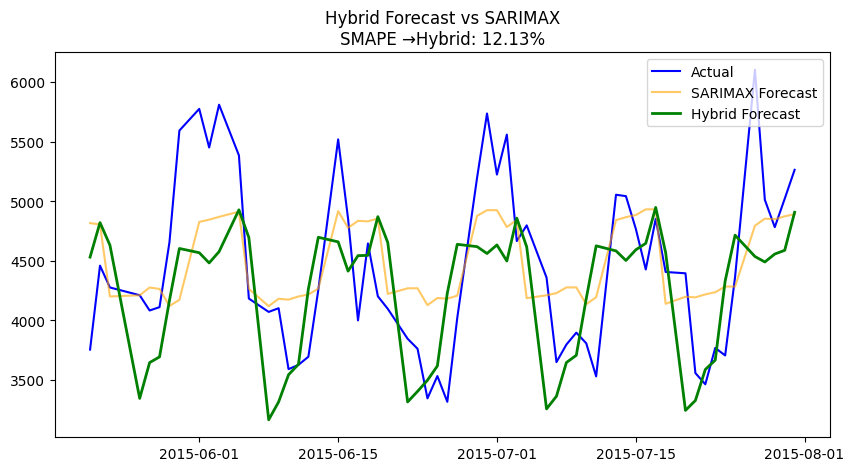

In [146]:
plt.figure(figsize=(10,5))
plt.plot(test_data.index, y_true, label='Actual', color='blue')
plt.plot(test_data.index, y_pred_sarimax, label='SARIMAX Forecast', color='orange', alpha=0.6)
plt.plot(test_data.index, y_pred_hybrid, label='Hybrid Forecast', color='green', linewidth=2)
plt.legend()
plt.title(f"Hybrid Forecast vs SARIMAX\nSMAPE →Hybrid: {smape_hybrid:.2f}%")
plt.show()